# **1. General setting**

In [2]:
# Load weights instead of training the model 1
USE_PRETRAINED_MODEL1 = False

# Clear models and test dataset for better performance in part 2
CLEAR_PART1 = True

# Load weights instead of training the model 2
USE_PRETRAINED_MODEL2 = False

# If True the coordinates will be loaded from "landmarks_training.npy"
USE_SAVED_HAND_LANDMARKS_FOR_TRAINING = False

# Use process_all instead of process_batch.
# Took 1:12 on my home PC, do not recommend.
USE_WHOLE_DATASET_FOR_LANDMARKS = True

# **2. Import libraries**

In [4]:
# Standard library
import os 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'                                 
from pathlib import Path

# Imports for the model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential

# Data visualisation
import cv2
import seaborn
import matplotlib.pyplot as plt
from matplotlib import image as mpimg

# Misc imports
import numpy as np
import random
import pickle
import re

# **3. Configuration for the CNN Model**

In [6]:
# Model config
batch_size_model1 = 32

# Image resolution for NN
img_height = 64
img_width = 64

# Data paths
data_dir = Path("../input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/")
saved_data_dir = Path("../input/sloppi")

# **4. Visualizing data**

In [8]:
img_count = len(list(data_dir.glob('*/*.jpg')))
img = cv2.imread(str(list(data_dir.glob('*/*.jpg'))[0]))

print('Image Count      :', img_count)
print('Image Dimensions :', img.shape)

Image Count      : 87000
Image Dimensions : (200, 200, 3)


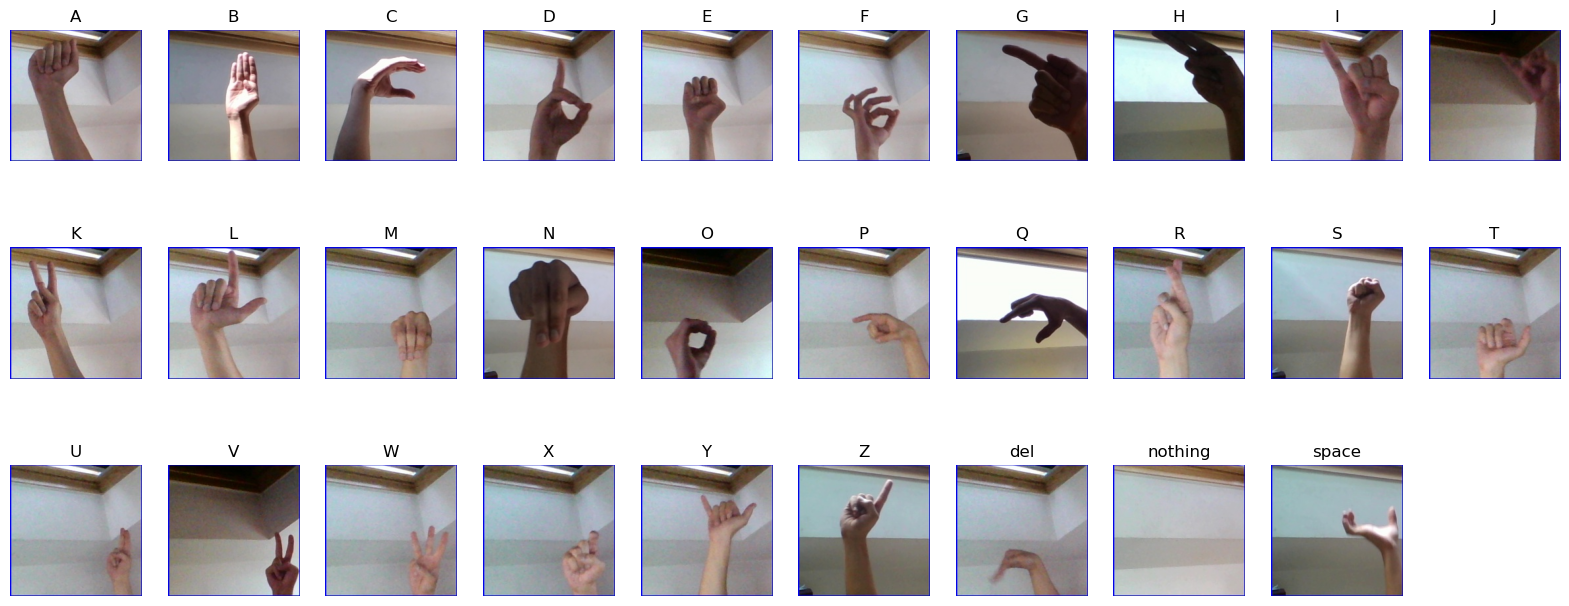

In [16]:
signs = os.listdir(data_dir)
signs.sort()

plt.figure(figsize = (20, 8))
for i, sign in enumerate(signs):
    # Choosing a random image path
    d = random.choice(list((data_dir / sign).glob('*.jpg')))
    
    ax = plt.subplot(3, 10, i + 1)
    img = mpimg.imread(d)
    plt.imshow(img)
    plt.title(sign)
    plt.axis("off")


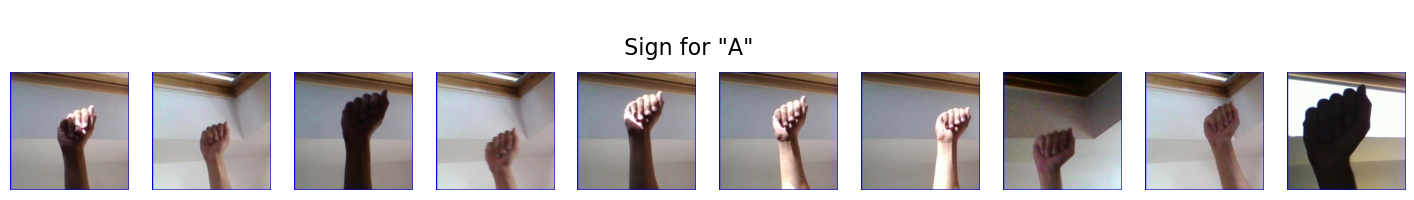

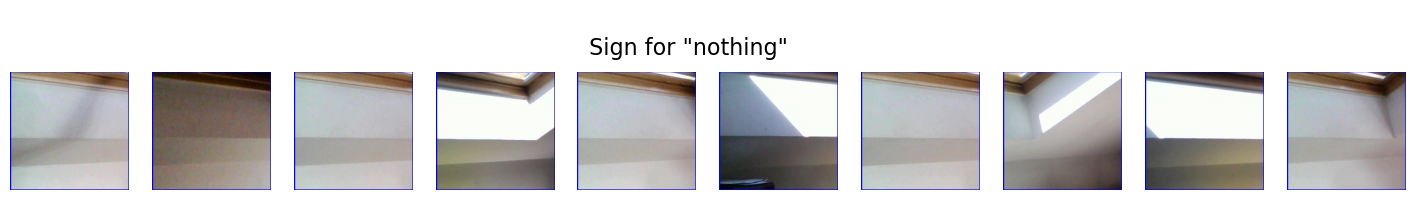

In [17]:
imgs_x = 10
imgs_y = 1

signs_to_show = ['A', 'nothing']


for sign in signs_to_show:
    # Taking a random sample of image paths
    dirs = random.sample(list((data_dir / sign).glob('*.jpg')), imgs_x * imgs_y)
    
    plt.figure(figsize = (imgs_x * 1.8, imgs_y * 2.5))
    plt.suptitle(f'\n Sign for \"{sign}\"', fontsize = 16)
    for i, d in enumerate(dirs):
        ax = plt.subplot(imgs_y, imgs_x, i + 1)
        img = mpimg.imread(d)
        plt.imshow(img)
        plt.axis("off")


# **5. Loading data**

In [18]:
# The logic of "not" in each if statement is that the model is trained and used afterward
if not USE_PRETRAINED_MODEL1:
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        validation_split = 0.2,
        subset = "training",
        seed = 123,
        image_size = (img_height, img_width),
        batch_size = batch_size_model1,
    )

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        validation_split = 0.2,
        subset = "validation",
        seed = 123,
        image_size = (img_height, img_width),
        batch_size = batch_size_model1,
    )
    
    
    # Taking 50% of the validation dataset for testing
    test_ds_size = int(val_ds.cardinality()) // 2
    test_ds = val_ds.take(test_ds_size).unbatch()
    
    val_ds = val_ds.skip(test_ds_size)
    
    # Transforming test_ds to NumPy arrays
    X_test = []
    y_test = []
    
    for X, y in test_ds:
        X_test.append(X)
        y_test.append(y)
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    # Saving and loading test data
    if not os.path.exists("./test_data/"):
        os.makedirs("./test_data/")
    np.savez('./test_data/model1.npz', X = X_test, y = y_test)
    
    test_data_1 = {"X" : X_test, "y" : y_test}
    
    
    # Removing leftover datasets
    del X_test, y_test, test_ds
    
    
    # Variable for output layer/predictions
    class_names = train_ds.class_names
    class_names = np.asarray(class_names)
    class_names = tuple(class_names)
    
    # Saving classes
    # Use pickle instead?
    if not os.path.exists("./models/"):
        os.makedirs("./models/")
    with open("./models/classes.pickle", "wb") as f:
        pickle.dump(class_names, f)
    
else:
    test_data_1 = np.load(saved_data_dir / 'test_data/model1.npz')
    with open(saved_data_dir / "models/classes.pickle", "rb") as f:
        class_names = pickle.load(f)

Found 87000 files belonging to 29 classes.
Using 69600 files for training.
Found 87000 files belonging to 29 classes.
Using 17400 files for validation.


# **6. Optimising the data for training**

In [21]:
if not USE_PRETRAINED_MODEL1:
    AUTOTUNE = tf.data.AUTOTUNE

    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

# **7. Building, compiling, and training a convolutional neural network**

In [23]:
if not USE_PRETRAINED_MODEL1:
    epochs_model1a = 10

    # Amount of neurons in output layer
    num_classes = len(class_names)
    """
    Creating neural network
    """
    
    model1a = Sequential(
        [
            layers.Rescaling(1.0 / 255, input_shape = (img_height, img_width, 3)),
            layers.Conv2D(16, 3, padding = "same", activation = "relu"),
            layers.MaxPooling2D(),
            layers.Conv2D(32, 3, padding = "same", activation = "relu"),
            layers.MaxPooling2D(),
            layers.Conv2D(64, 3, padding = "same", activation = "relu"),
            layers.MaxPooling2D(),
            layers.Flatten(),
            layers.Dense(128, activation = "relu"),
            layers.Dense(num_classes)
        ]
    )

    model1a.compile(
        optimizer = "adam",
        loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True),
        metrics = ["accuracy"],
    )
    model1a.summary()

    history1a = model1a.fit(train_ds, validation_data = val_ds, epochs = epochs_model1a)
    model1a.save('./models/model1a')
else:
    """
    Using pretrained model
    """
    model1a = tf.keras.models.load_model(saved_data_dir / 'models/model1a')
    model1a.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 64)       

# **8. Training results**

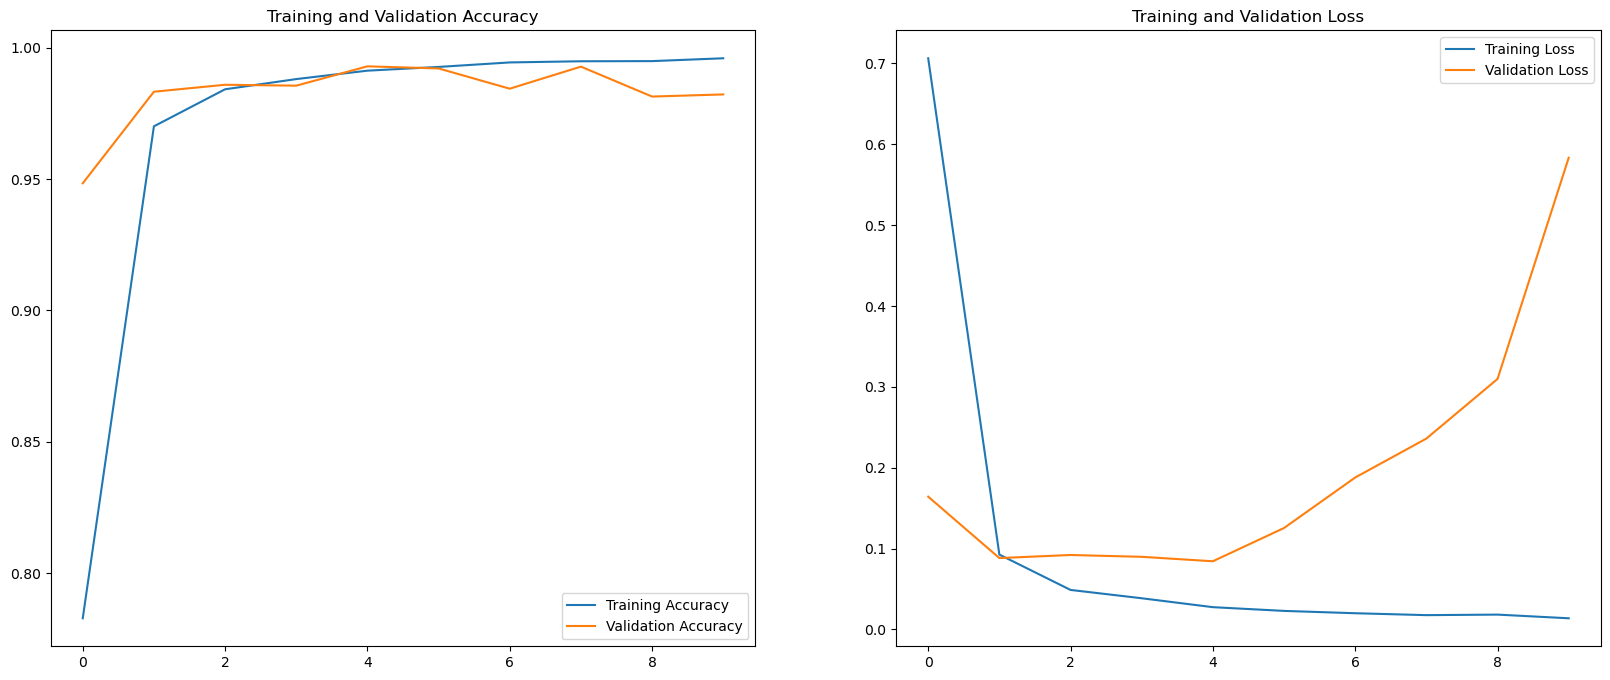

In [24]:
if not USE_PRETRAINED_MODEL1:
    acc = history1a.history['accuracy']
    val_acc = history1a.history['val_accuracy']

    loss = history1a.history['loss']
    val_loss = history1a.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize = (20, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label = 'Training Accuracy')
    plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
    plt.legend(loc = 'lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label = 'Training Loss')
    plt.plot(epochs_range, val_loss, label = 'Validation Loss')
    plt.legend(loc = 'upper right')
    plt.title('Training and Validation Loss')
    if not os.path.exists("./plots/"):
        os.makedirs("./plots/")
    plt.savefig('./plots/model1a_accl.png')
else:
    img = mpimg.imread(saved_data_dir / 'plots/model1a_accl.png')
    plt.figure(figsize = (20, 8))
    plt.imshow(img)
    plt.axis("off")

In [27]:
def show_stats(model, test_data, classes):
    X = test_data["X"]
    y_true = test_data["y"]

    y_pred = np.argmax(model.predict(X), axis = 1)

    # Statistics
    
    metrics = model.evaluate(X, y_true)
    """
    acc_f = r"0.9+\d"
    v = re.search(acc_f, str(metrics[1]))
    if v:
        acc = v[0]
    else:
        acc = f"{metrics[1]:.2f}"

    print(
        f"Test Dataset:\n
        Accuracy: {acc}
        Loss: {metrics[0]:.4f}
        "
    )
    """
    print(f"False Predictions: {sum(y_true != y_pred)} images in 8700 images of test set")

    # Confusion matrix
    confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
    plt.figure(figsize = (10, 7))
    seaborn.heatmap(
        confusion_mtx, xticklabels = classes, yticklabels = classes, annot = True, fmt = "g"
    )
    plt.xlabel("Prediction")
    plt.ylabel("Label")


In [28]:
def show_false_pred(model, test_data, classes, max_count:int = 10):
    X_t = test_data["X"]
    y_true = test_data["y"]

    y_pred = np.argmax(model.predict(X_t), axis = 1)
    
    # Amount of rows needed for images
    y_dims = -(-max_count // 10)
    
    
    plt.figure(figsize = (18, 2.5 * y_dims))
    i = 0
    
    for X, y_t, y_p in zip(X_t, y_true, y_pred):
        if i >= max_count:
            break
        if y_p != y_t:
            ax = plt.subplot(y_dims, 10, i + 1)
            ax.set_title(f"True: {classes[y_t]}\nRecognized: {classes[y_p]}",
                         loc = "left")
            plt.imshow(X.astype("uint8"))
            plt.axis("off")
            i += 1

272/272 [==============================] - 1s 4ms/step - loss: 0.0570 - accuracy: 0.9852
False Predictions: 129 images in 8700 images of test set
272/272 [==============================] - 1s 2ms/step


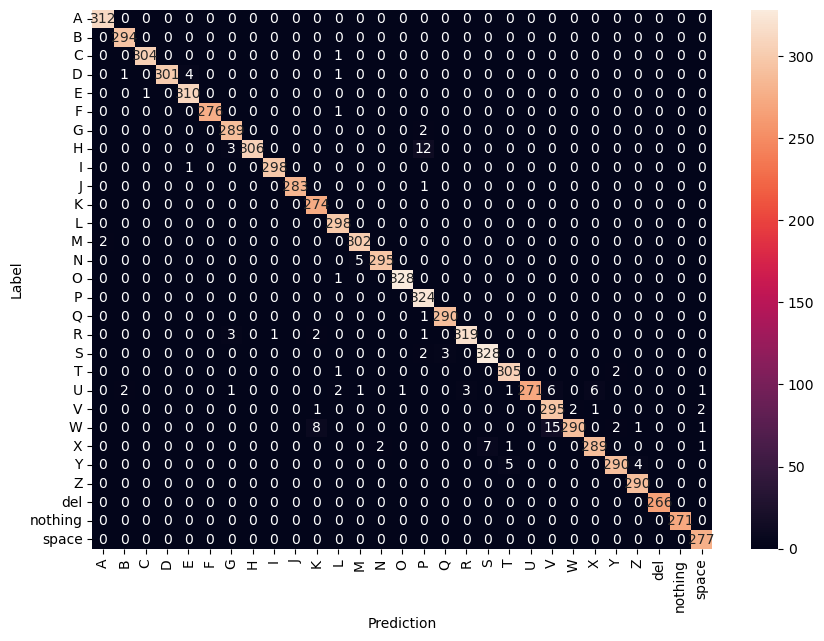

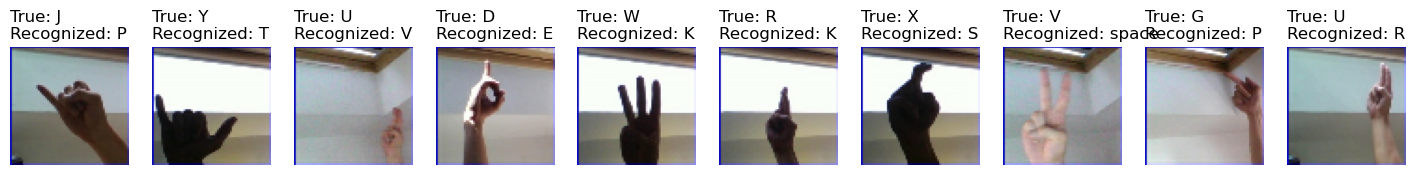

In [29]:
show_stats(model1a, test_data_1, class_names)
show_false_pred(model1a, test_data_1, class_names)

# **9. Adding data augmentation**

In [34]:
if not USE_PRETRAINED_MODEL1:
    """
    Creating neural network
    """
    epochs_model1b = 5
    
    data_augmentation = keras.Sequential(
      [
        layers.RandomFlip("horizontal",
                          input_shape = (img_height,
                                         img_width,
                                         3)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
      ]
    )
    
    model1b = Sequential([
      data_augmentation,
      layers.Rescaling(1./255),
      layers.Conv2D(16, 3, padding = 'same', activation = 'relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(32, 3, padding = 'same', activation = 'relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(64, 3, padding = 'same', activation = 'relu'),
      layers.MaxPooling2D(),
      layers.Dropout(0.2),
      layers.Flatten(),
      layers.Dense(128, activation = 'relu'),
      layers.Dense(num_classes, name = "outputs")
    ])

    model1b.compile(
        optimizer = "adam",
        loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True),
        metrics = ["accuracy"],
    )
    history1b = model1b.fit(train_ds, validation_data = val_ds, epochs = epochs_model1b)
    
    model1b.save('./models/model1b')
    model1b.summary()
else:
    """
    Using pretrained model
    """
    model1b = tf.keras.models.load_model(saved_data_dir / 'models/model1b')
    model1b.summary()

Epoch 1/5
2175/2175 [==============================] - 19s 7ms/step - loss: 1.7739 - accuracy: 0.4564 - val_loss: 1.0102 - val_accuracy: 0.7471
Epoch 2/5
2175/2175 [==============================] - 15s 7ms/step - loss: 0.7233 - accuracy: 0.7592 - val_loss: 1.0750 - val_accuracy: 0.8507
Epoch 3/5
2175/2175 [==============================] - 16s 7ms/step - loss: 0.4507 - accuracy: 0.8469 - val_loss: 1.2749 - val_accuracy: 0.9115
Epoch 4/5
2175/2175 [==============================] - 15s 7ms/step - loss: 0.3344 - accuracy: 0.8851 - val_loss: 1.5575 - val_accuracy: 0.9458
Epoch 5/5
2175/2175 [==============================] - 15s 7ms/step - loss: 0.2612 - accuracy: 0.9100 - val_loss: 1.9423 - val_accuracy: 0.9343
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_8 (Sequential)   (None, 64, 64, 3)         0         
                                                            

# **10. Training results with data augmentation**

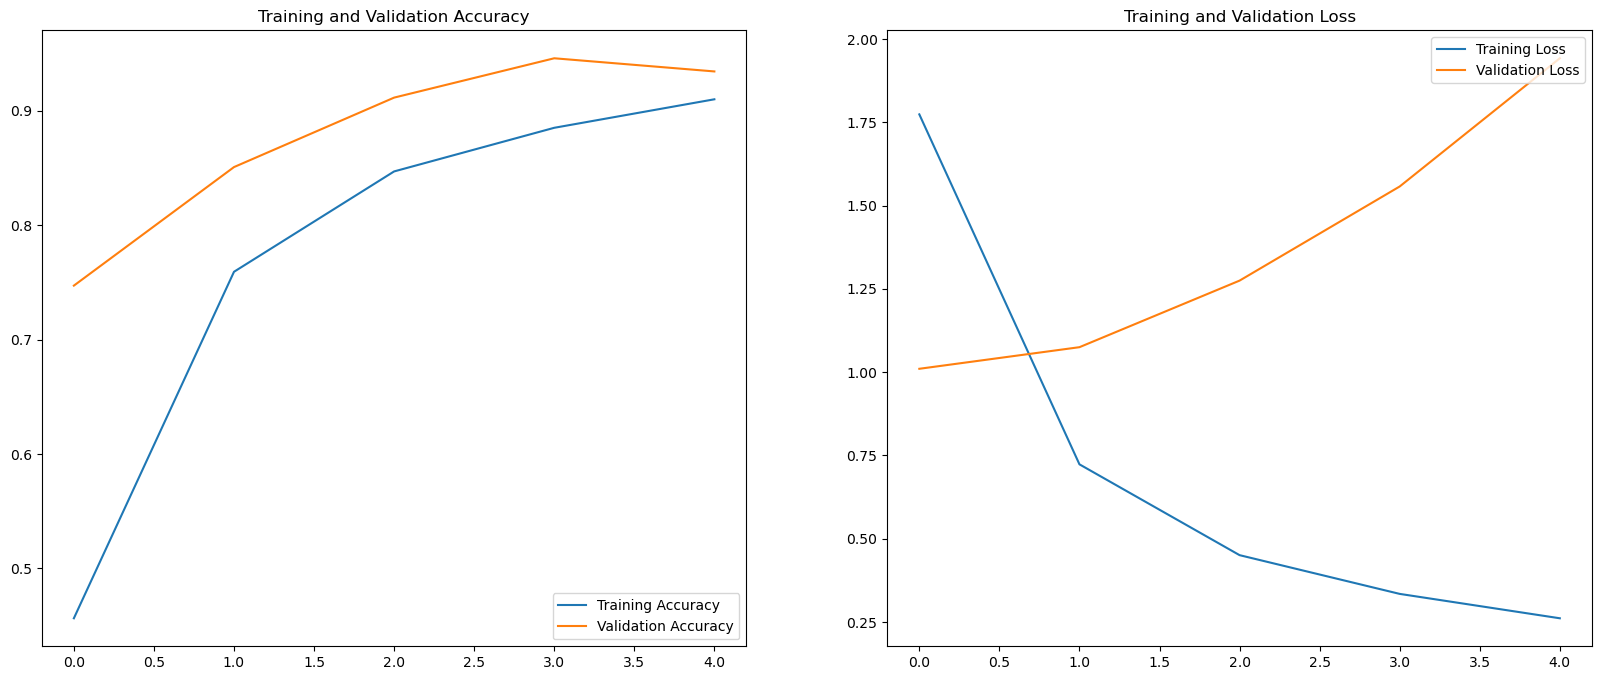

In [38]:
if not USE_PRETRAINED_MODEL1:
    acc = history1b.history['accuracy']
    val_acc = history1b.history['val_accuracy']

    loss = history1b.history['loss']
    val_loss = history1b.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize = (20, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label = 'Training Accuracy')
    plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
    plt.legend(loc = 'lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label = 'Training Loss')
    plt.plot(epochs_range, val_loss, label = 'Validation Loss')
    plt.legend(loc = 'upper right')
    plt.title('Training and Validation Loss')
    plt.savefig('./plots/model1b_accl.png')
else:
    img = mpimg.imread(saved_data_dir / 'plots/model1b_accl.png')
    plt.figure(figsize = (20, 8))
    plt.imshow(img)
    plt.axis("off")

272/272 [==============================] - 1s 4ms/step - loss: 0.1846 - accuracy: 0.9369
False Predictions: 549 images in 8700 images of test set
272/272 [==============================] - 1s 3ms/step


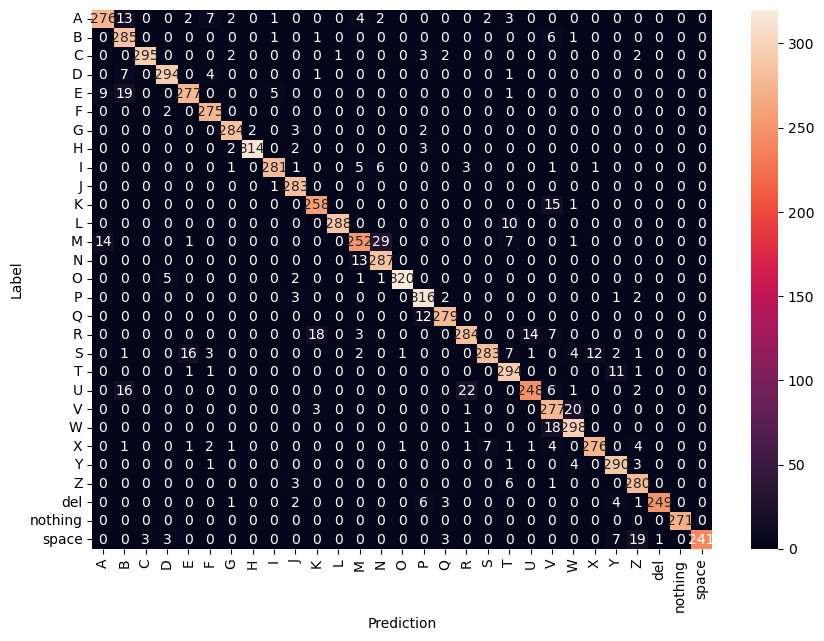

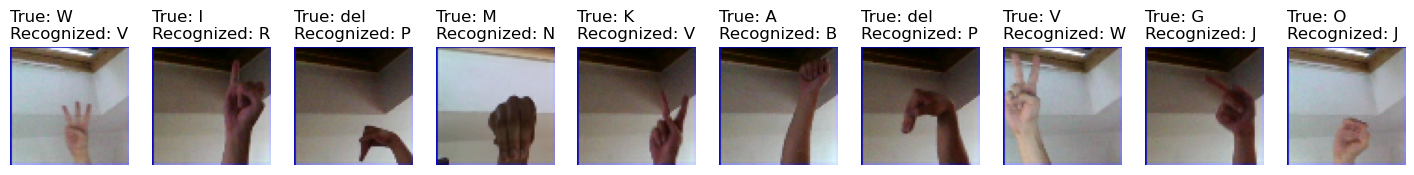

In [40]:
show_stats(model1b, test_data_1, class_names)
show_false_pred(model1b, test_data_1, class_names)

# **11. Cleaning**

In [41]:
# The training and validation datasets are created only if the models are trained
try:
    del train_ds, val_ds
except:
    pass


if CLEAR_PART1:
    del test_data_1
    keras.backend.clear_session()